In [1]:
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.tseries.frequencies import to_offset

%matplotlib inline

In [2]:
def read_river(river_name, ps):
    river_flow = pd.read_csv(f'{river_name}_flow', header=None, sep='\s+', index_col=False,
                      names=['year', 'month', 'day', 'flow'])
    river_flow['date'] = pd.to_datetime(river_flow.drop(columns='flow'))
    river_flow.set_index('date', inplace=True)
    river_flow = river_flow.drop(columns=['year', 'month', 'day'])
    if ps == 'primary':
        river_flow = river_flow.rename(columns={'flow': 'Primary River Flow'})
    elif ps == 'secondary':
        river_flow = river_flow.rename(columns={'flow': 'Secondary River Flow'})
    return river_flow

In [3]:
def read_river_Theodosia():
    part1 = pd.read_csv('Theodosia_Scotty_flow', header=None, sep='\s+', index_col=False,
                      names=['year', 'month', 'day', 'flow'])
    part2 = pd.read_csv('Theodosia_Bypass_flow', header=None, sep='\s+', index_col=False,
                      names=['year', 'month', 'day', 'flow'])
    part3 = pd.read_csv('Theodosia_Diversion_flow', header=None, sep='\s+', index_col=False,
                      names=['year', 'month', 'day', 'flow'])
    for part in [part1, part2, part3]:
        part['date'] = pd.to_datetime(part.drop(columns='flow'))
        part.set_index('date', inplace=True)
        part.drop(columns=['year', 'month', 'day'], inplace=True)
    part1 = part1.rename(columns={'flow': 'Scotty'})
    part2 = part2.rename(columns={'flow': 'Bypass'})
    part3 = part3.rename(columns={'flow': 'Diversion'})
    theodosia = (part1.merge(part2, how='inner', on='date')).merge(part3, how='inner', on='date')
    theodosia['Secondary River Flow'] = theodosia['Scotty'] + theodosia['Diversion'] - theodosia['Bypass']
    return theodosia

In [4]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                       'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
days_in_month = (31, 28.25, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31)

In [5]:
def read_watershed(water_shed, year):
    morrison = pd.read_excel('Copy of Flow_Mon_X_Year.xlsx', sheet_name=str(year),
                                names=['Water Year', 'Unnamed', 'area', 'total', 'Jan',
                                                   'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep',
                                                   'Oct', 'Nov', 'Dec'])
    waters = morrison[morrison['Water Year'] == water_shed]
    zmonths = []
    zflows = []
    for im, month in enumerate(months):
        zmonths.append(dt.datetime(year, im+1, 15))
        zflows.append(waters[month].values[0] * 1e9/86400./days_in_month[im])
    watershedflow = {'date': zmonths, 'Watershed Flow': zflows}
    df = pd.DataFrame(watershedflow)
    df.set_index('date', inplace=True)
    return df

In [99]:
def do_a_pair(water_shed, primary_river_name, use_secondary, secondary_river_name='Null', subtract_primary=False):
    primary_river = read_river(primary_river_name, 'primary')
    
    if use_secondary:
        if secondary_river_name == "Theodosia":
            secondary_river = read_river_Theodosia()
        else:
            secondary_river = read_river(secondary_river_name, 'secondary')
        rivers = primary_river.merge(secondary_river, how='inner', on='date')
        rivers['Daily Flow'] = (rivers['Primary River Flow'] * 
                        watershed_from_river[water_shed]['primary']
                        + rivers['Secondary River Flow'] 
                        * watershed_from_river[water_shed]['secondary'])
    else:
        rivers = primary_river
        rivers['Daily Flow'] = (primary_river['Primary River Flow'] * 
                                watershed_from_river[water_shed]['primary'])
    
    morrison1 = read_watershed(water_shed, 2005)
    morrison2 = read_watershed(water_shed, 2006)
    morrison = pd.concat([morrison1, morrison2])
    
    fig, axs = plt.subplots(2, 1, figsize=(10, 8))
    if subtract_primary:
        thefraser = rivers['Primary River Flow'].resample('m', label='left').mean()
        thefraser.index = thefraser.index + to_offset('15d')
        (morrison['Watershed Flow'] - thefraser).plot(ax=axs[0])
    else:
        morrison.plot(ax=axs[0]);
    for ax in axs:
        rivers['Daily Flow'].plot(ax=ax);
        ax.set_ylim(0, 3000)
    axs[0].set_xlim(dt.datetime(2005, 1, 1), dt.datetime(2006, 12, 31));
    axs[1].set_xlim(dt.datetime(2015, 1, 1), dt.datetime(2017, 12, 31));
    fig.suptitle(water_shed)
    return rivers

In [115]:
watershed_from_river = {
    'Bute': {'primary': 2.015},
    'Jervis': {'primary': 8.810, 'secondary': 140.3},
    'Howe': {'primary': 2.276},
    'JdF': {'primary': 8.501},
    'EVI_N': {'primary': 10.334},
    'EVI_S': {'primary': 24.60},
    'Toba': {'primary': 0.4563, 'secondary': 14.58},
    'Skagit': {'primary': 1.267, 'secondary': 1.236},
    'Puget': {'primary': 8.790, 'secondary': 29.09},
    'Fraser' : {'primary': 0.161, 'secondary': 162}
}

In [8]:
totalflow = {}

### Homathko_Mouth for Bute.  
Multiply by 2.015 or (61.17 + 1.785 x)  
No reason for base flow.  
Homathko is glacier fed and will include a base.

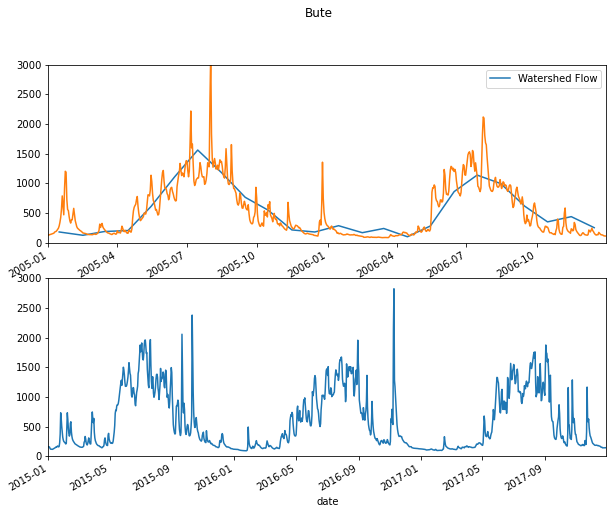

In [100]:
water_shed = 'Bute'
primary_river_name = 'Homathko_Mouth'
use_secondary = False
totalflow[water_shed] = do_a_pair(water_shed, primary_river_name, use_secondary)

### Clowhom_ClowhomLake and Roberts_Roberts for Jervis. 
8.810*Clowhom + 140.3*Roberts

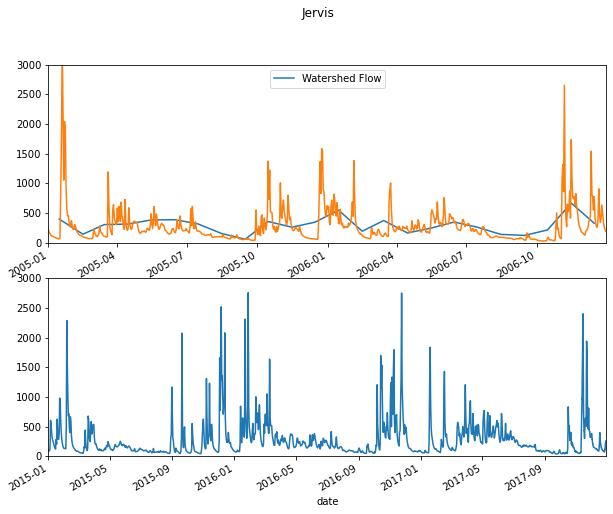

In [101]:
water_shed = 'Jervis'
primary_river_name = 'Clowhom_ClowhomLake'
secondary_river_name = 'Roberts_Roberts'
use_secondary = True
totalflow[water_shed] = do_a_pair(water_shed, primary_river_name, use_secondary, secondary_river_name)

### Squamish_Brackendale for Howe. 
Multiply by 2.276 or (89.00 + 1.893 x)
Again Squamish is big enough, don't need intercept

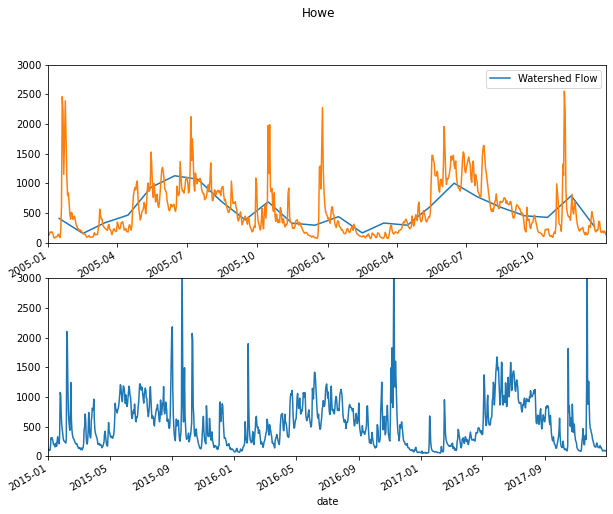

In [102]:
water_shed = 'Howe'
primary_river_name = 'Squamish_Brackendale'
use_secondary = False
totalflow[water_shed] = do_a_pair(water_shed, primary_river_name, use_secondary)

### SanJuan_PortRenfrew for JdF. 
Multiply by 8.501 or (32.837 + 7.801 x)

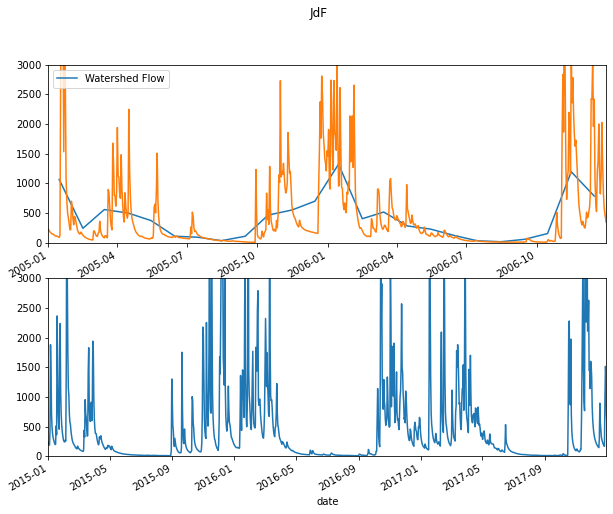

In [103]:
water_shed = 'JdF'
primary_river_name = 'SanJuan_PortRenfrew'
use_secondary = False
totalflow[water_shed] = do_a_pair(water_shed, primary_river_name, use_secondary)

### Salmon_Sayward for EVI_N, 
Multiply by 10.334 or (152.15 + 7.859 x)

In [17]:
# this is the correction for the partial domain but not we don't need to do this here,
# its in the river_201702 division.

totalarea = 9709
area = 363+1470+139+31+23+16+23+23+12+109+12+229+10+14+14+28+1210+14+7+7+34+10
print (area, area/totalarea)
10.334*area/totalarea

3798 0.3911834380471727


4.042489648779483

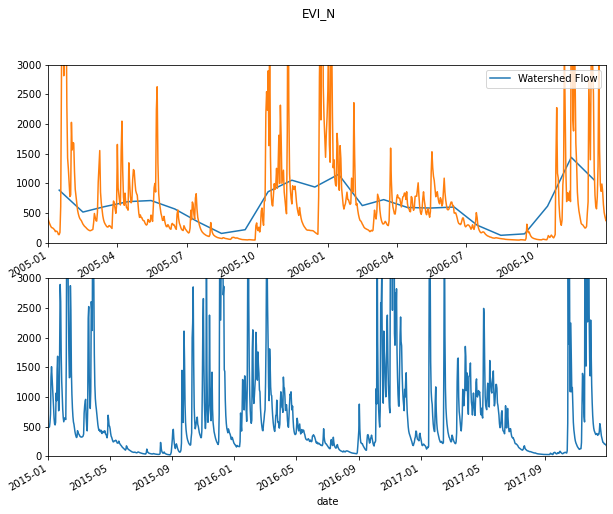

In [104]:
water_shed = 'EVI_N'
primary_river_name = 'Salmon_Sayward'
use_secondary = False
totalflow[water_shed] = do_a_pair(water_shed, primary_river_name, use_secondary)

### Englishman for EVI_S, 
24.60*Englishman   
* looked at other rivers, but they are similar

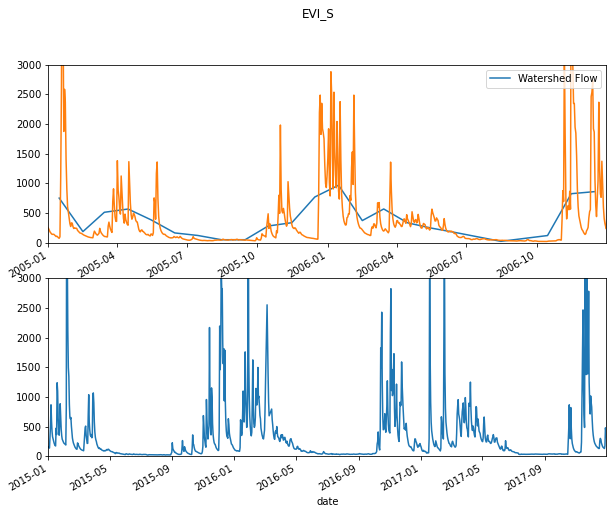

In [105]:
water_shed = 'EVI_S'
primary_river_name = 'Englishman'
use_secondary = False
totalflow[water_shed] = do_a_pair(water_shed, primary_river_name, use_secondary)

### Homathko_Mouth and Theodosia for Toba, 
0.4563 * Homathko  + 14.58 * Theodosia
Note that the Homathko is not actually in Toba but in Bute but no big river is gauged in Toba

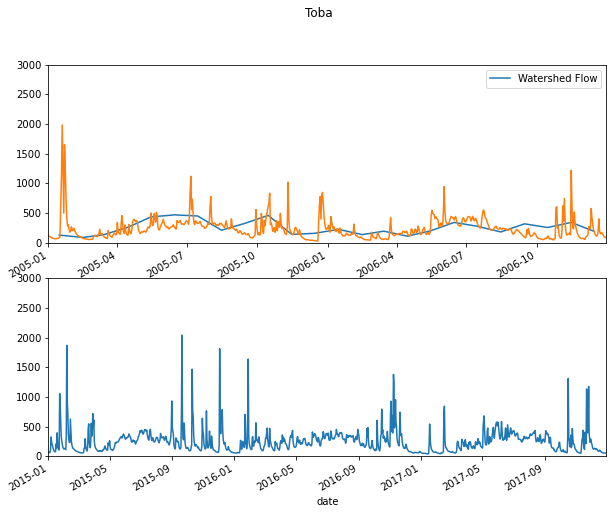

In [106]:
water_shed = 'Toba'
primary_river_name = 'Homathko_Mouth'
secondary_river_name = 'Theodosia'
use_secondary = True
totalflow[water_shed] = do_a_pair(water_shed, primary_river_name, use_secondary, secondary_river_name)

### Skagit_MountVernon and Snohomish_Monroe for Skagit, 
1.267 * Skagit + 1.236 * Snohomish

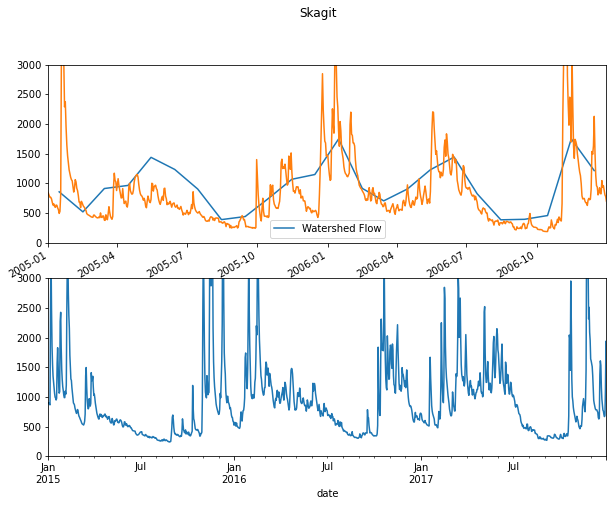

In [107]:
water_shed = 'Skagit'
primary_river_name = 'Skagit_MountVernon'
secondary_river_name = 'Snohomish_Monroe'
use_secondary = True
totalflow[water_shed] = do_a_pair(water_shed, primary_river_name, use_secondary, secondary_river_name)

### Nisqually_McKenna and Greenwater_Greenwater for Puget, 
8.790 * Nisqually + 29.09 * Greenwater

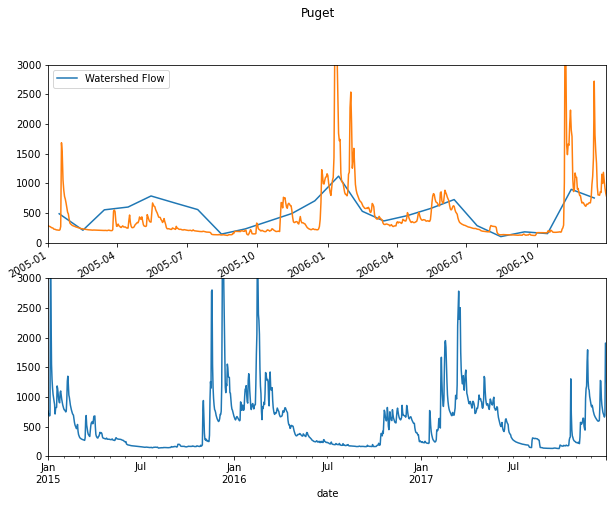

In [108]:
water_shed = 'Puget'
primary_river_name = 'Nisqually_McKenna'
secondary_river_name = 'Greenwater_Greenwater'
use_secondary = True
totalflow[water_shed] = do_a_pair(water_shed, primary_river_name, use_secondary, secondary_river_name)

### Fraser_Hope and Nicomekl_203 for Fraser_not_Hope. 
0.161*Fraser + 162*Nicomekl

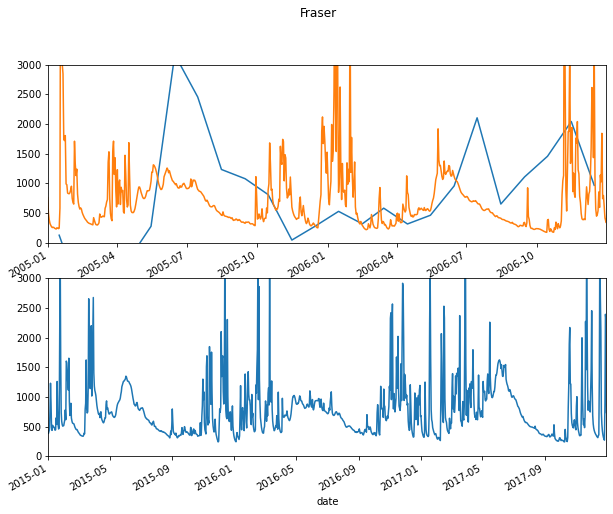

In [117]:
water_shed = 'Fraser'
primary_river_name = 'Fraser_Hope'
secondary_river_name = 'Nicomekl_203'
use_secondary = True
totalflow[water_shed] = do_a_pair(water_shed, primary_river_name, use_secondary, 
                                  secondary_river_name, subtract_primary=True)

In [62]:
totalflow['Fraser']

,Primary River Flow,Secondary River Flow,Daily Flow
date,,,
1912-03-01,538.000,10.800000,1190.091600
1912-03-02,538.000,9.340000,1039.551000
1912-03-03,538.000,9.340000,1039.551000
1912-03-04,538.000,8.210000,923.036700
1912-03-05,538.000,7.360000,835.393200
...,...,...,...
2020-01-27,1232.153,5.947917,788.501878
2020-01-28,1273.681,22.931220,2545.555532
2020-01-29,1251.007,42.211460,4530.316836


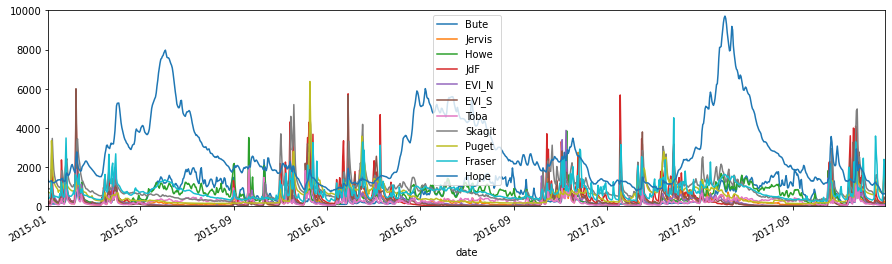

In [119]:
fig, ax = plt.subplots(1, 1, figsize=(15, 4))
for key in totalflow:
    if key == 'EVI_N':
        (0.391*totalflow[key]['Daily Flow']).plot(ax=ax, label=key)
    else:
        totalflow[key]['Daily Flow'].plot(ax=ax, label=key)
totalflow['Fraser']['Primary River Flow'].plot(ax=ax, label='Hope')
ax.set_xlim(dt.datetime(2015, 1, 1), dt.datetime(2017, 12, 31));
ax.set_ylim(0, 1e4)
ax.legend(loc='best');

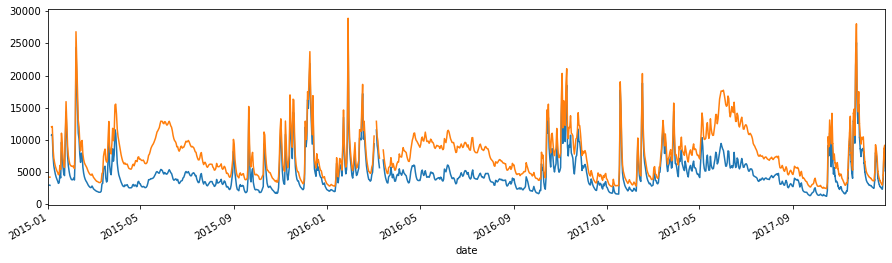

In [120]:
subset = 0.391 * totalflow['EVI_N']['Daily Flow'][totalflow['EVI_N'].index > dt.datetime(2015, 1, 1)]
subset = subset * 0
fig, ax = plt.subplots(1, 1, figsize=(15, 4))
for key in totalflow:
    if key == 'EVI_N':
        subset = subset + 0.391 * totalflow[key]['Daily Flow'][totalflow[key].index > dt.datetime(2015, 1, 1)]
    else:
        subset = subset + totalflow[key]['Daily Flow'][totalflow[key].index > dt.datetime(2015, 1, 1)]
subset.plot(ax=ax)
allofit = subset + totalflow['Fraser']['Primary River Flow'][totalflow['Fraser'].index > dt.datetime(2015, 1, 1)]
allofit.plot(ax=ax)

ax.set_xlim(dt.datetime(2015, 1, 1), dt.datetime(2017, 12, 31));

(0.0, 3.2e+16)

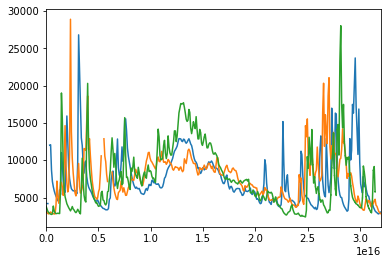

In [121]:
plt.plot(allofit.index - dt.datetime(2015, 1, 1), allofit)
plt.plot(allofit.index - dt.datetime(2016, 1, 1), allofit)
plt.plot(allofit.index - dt.datetime(2017, 1, 1), allofit)
plt.xlim(0, 3.2e16)

Bute date
2016-03-04    201.5
Name: Daily Flow, dtype: float64
Jervis date
2016-03-04    515.301
Name: Daily Flow, dtype: float64
Howe date
2016-03-04    416.508
Name: Daily Flow, dtype: float64
JdF date
2016-03-04    1173.138
Name: Daily Flow, dtype: float64
EVI_N date
2016-03-04    3441.222
Name: Daily Flow, dtype: float64
EVI_S Series([], Name: Daily Flow, dtype: float64)
Toba date
2016-03-04    378.4914
Name: Daily Flow, dtype: float64
Skagit date
2016-03-04    1548.014353
Name: Daily Flow, dtype: float64
Puget date
2016-03-04    1314.172446
Name: Daily Flow, dtype: float64
Fraser date
2016-03-04    588.208839
Name: Daily Flow, dtype: float64


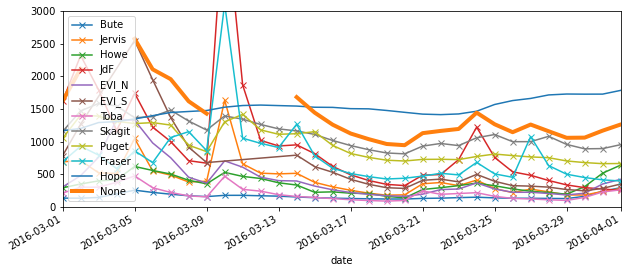

In [123]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
for key in totalflow:
    if key == 'EVI_N':
        (0.391*totalflow[key]['Daily Flow']).plot(ax=ax, label=key)
    else:
        totalflow[key]['Daily Flow'].plot(ax=ax, label=key, marker='x')
    print (key, totalflow[key]['Daily Flow'][totalflow[key].index == dt.datetime(2016, 3, 4)])
totalflow['Fraser']['Primary River Flow'].plot(ax=ax, label='Hope')
(allofit/5.).plot(ax=ax, linewidth=4)
ax.set_xlim(dt.datetime(2016, 3, 1), dt.datetime(2016, 4, 1));
ax.set_ylim(0, 3000)
ax.legend(loc='best');

AttributeError: 'dict' object has no attribute 'plot'

# Things Still to Do

* Fraser downstream from Hope -- Done
* Fix gaps (you can see one in March 2016 above)
* Make this work in the climatology along with the Fraser